In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [2]:
links = pd.read_csv('data/links.csv')
links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [3]:
movies = pd.read_csv('data/movies.csv')
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [4]:
ratings = pd.read_csv('data/ratings.csv')
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [5]:
tags = pd.read_csv('data/tags.csv')
tags.head(2)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


In [6]:
tags['tag'].value_counts()

In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
surreal               23
                    ... 
ocean                  1
human rights           1
Titanic                1
Navy                   1
Beethoven              1
Name: tag, Length: 1589, dtype: int64

In [7]:
tags['movieId'].value_counts()

296     181
2959     54
924      41
293      35
7361     34
       ... 
6107      1
5878      1
5876      1
3192      1
8190      1
Name: movieId, Length: 1572, dtype: int64

Based on the above initial previewing of the dataset, there are two datsets we can use in our project, the movies and the ratings datasets. This is because these two datasets are the ones containing information on ratings, movie ids and user ids which we'll need to create a recommender system. 

In [8]:
#Previewing the datasets again
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
#Merging the two datasets on movieid
df = pd.merge(movies, ratings, on='movieId', how='left')
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100854 entries, 0 to 100853
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100854 non-null  int64  
 1   title      100854 non-null  object 
 2   genres     100854 non-null  object 
 3   userId     100836 non-null  float64
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 5.4+ MB


The timestamp column has no value in our analysis therefore we can proceed to drop it. 

In [12]:
#Dropping the timestamp column
df.drop(columns=['timestamp'], axis=1, inplace=True)
df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5


In [13]:
df.isna().sum()

movieId     0
title       0
genres      0
userId     18
rating     18
dtype: int64

There are key columns(userId and rating) with missing values. We will investigate the 

In [14]:
#Investigating the percentage of missing values
no_missing = df.isna().sum()
percent_missing = (df.isna().sum() * 100/len(df)).round(2)
missing_value_df = pd.DataFrame({'no_missing_values':no_missing,'percent_missing':percent_missing})

missing_value_df

,no_missing_values,percent_missing
movieId,0,0.00
title,0,0.00
genres,0,0.00
userId,18,0.02
rating,18,0.02


In [15]:
#Dropping the columns with missing values
df = df.dropna()
df.isna().sum()

movieId    0
title      0
genres     0
userId     0
rating     0
dtype: int64

In [16]:
#Converting the userId column data type to int
df['userId'] = df['userId'].astype('int64')

## Feature Engineering

We undertook feature engineering to create a new column release_year by extracting the year the movie was released from the end of the title string. We then converted the years to decades. 

In [17]:
df['release_year'] = df['title'].str.extract(r'\((\d{4})\)$', expand=False)
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').astype('Int64')
df.head()

,movieId,title,genres,userId,rating,release_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1995
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1995
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1995
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1995
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1995


In [18]:
df.isna().sum()

movieId          0
title            0
genres           0
userId           0
rating           0
release_year    31
dtype: int64

In [19]:
no_missing = df.isna().sum()
percent_missing = (df.isna().sum() * 100/len(df)).round(2)
missing_value_df = pd.DataFrame({'no_missing_values':no_missing,'percent_missing':percent_missing})

missing_value_df

,no_missing_values,percent_missing
movieId,0,0.00
title,0,0.00
genres,0,0.00
userId,0,0.00
rating,0,0.00
release_year,31,0.03


In [20]:
df = df.dropna()

In [21]:
df.isna().sum()

movieId         0
title           0
genres          0
userId          0
rating          0
release_year    0
dtype: int64

In [22]:
#Assigning the release year to decades
#Define a function to convert year into decade
def year_to_decade(year):
    if pd.isna(year):
        return None
    return int(year / 10) * 10

#Apply the function to the dataset
df['decade'] = df['release_year'].apply(year_to_decade)

#Convert the decade into a string for readability
df['decade'] = df['decade'].astype(str) + 's'

df.head()

,movieId,title,genres,userId,rating,release_year,decade
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1995,1990s
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1995,1990s
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1995,1990s
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1995,1990s
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1995,1990s


## Exploratory Data Analysis

### Distribution of ratings

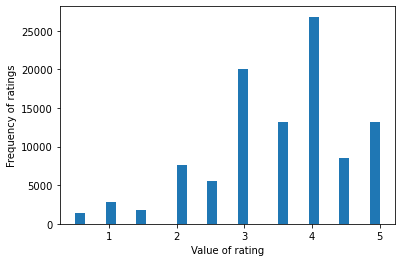

In [23]:
#Frequency of ratings
plt.hist(df['rating'],bins=30)
plt.xlabel('Value of rating')
plt.ylabel('Frequency of ratings')
plt.show()

### Genre popularity

We extracted individual genres from the movie genres column to investigate the most popular genres. 

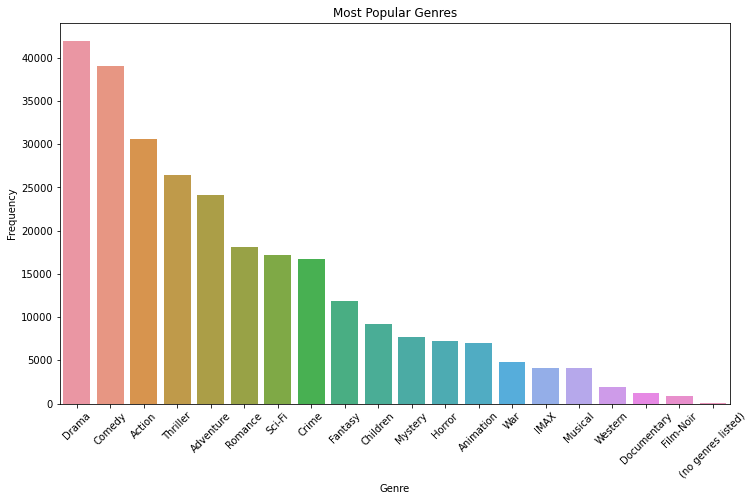

In [24]:
#Extracting genre labels from the genre column
genrelabels = set()
for i in df['genres'].str.split('|').values:
    genrelabels = genrelabels.union(set(i))
    
#Creating a function to visualize genre     
def genrecounts(df, col, labels):
    count = dict()
    for i in labels: count[i] = 0
    for value in df[col].str.split('|'):
        if type(value) == float and pd.isnull(value): continue
        for i in value: 
            if pd.notnull(i): count[i] += 1
    return count    

#Applying the function to our dataframe to extract genre count by genre labels
genre_count = genrecounts(df, 'genres', genrelabels)
genre_count

#Creating a dataframe from the genre labels and frequency
genres = pd.DataFrame(list(genre_count.items()),columns = ['Genre','Frequency'])

#Sorting values by the frequency column
genres = genres.sort_values(by=['Frequency'], ascending=False)

#Visualizing the most popular genres
plt.figure(figsize=(12,7))
sns.barplot(genres['Genre'], genres['Frequency'])
plt.title('Most Popular Genres')
plt.xticks(rotation=45);

Drama is the most popular genre in all the rated movies, followed by comedy and action. Thriller and adventure fill the remaining 2 slots in the top 5 most popular movie genres. 

### Movie Release by Decades

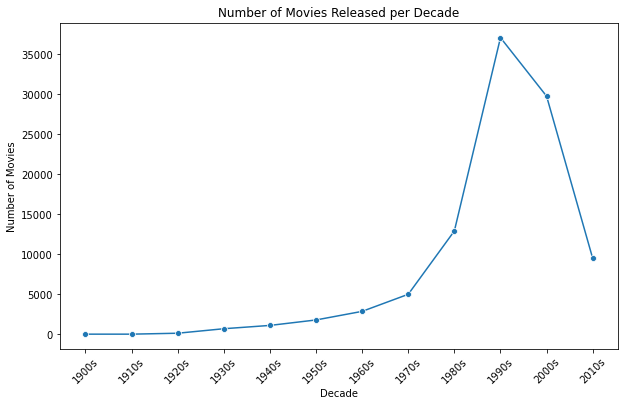

In [25]:
# Grouping by decade and counting the number of movies released
movies_per_decade = df.groupby('decade').size().reset_index(name='count')

# Plotting the counts
plt.figure(figsize=(10, 6))
sns.lineplot(data=movies_per_decade, x='decade', y='count', marker='o')
plt.title('Number of Movies Released per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45);


The number of movies produced from the 1900s if fairly low until the 1960s when it begins to rise. Movie production experiences exponentail growth from the 1970s until the highest peak in 1990s after which the number of movies begins to fall. The 2010s decades maybe missing some data as our last movie release date is in 2018. 

### Number of Ratings and Average ratings per Decade

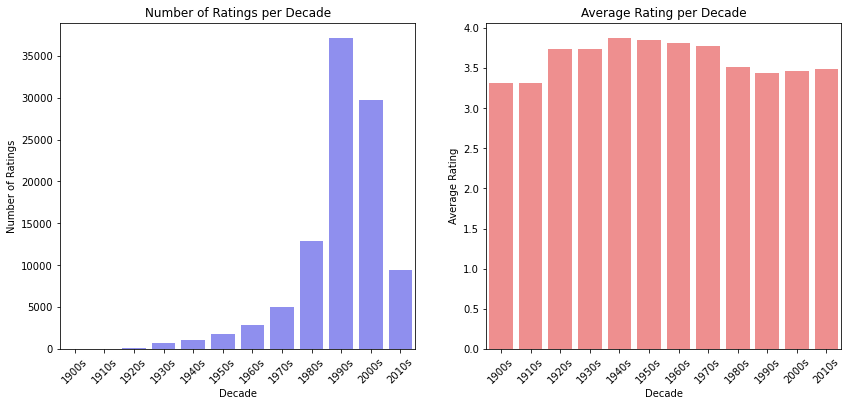

In [26]:
# Grouping by decade and calculating the average rating
ratings_stats = df.groupby('decade').agg({'rating': ['mean', 'count']}).reset_index()
ratings_stats.columns = ['decade', 'average_rating', 'number_of_ratings']

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting number of ratings per decade
sns.barplot(ax=axes[0], data=ratings_stats, x='decade', y='number_of_ratings', color='blue', alpha=0.5)
axes[0].set_title('Number of Ratings per Decade')
axes[0].set_xlabel('Decade')
axes[0].set_ylabel('Number of Ratings')
axes[0].tick_params(axis='x', rotation=45)

# Plotting average rating per decade
sns.barplot(ax=axes[1], data=ratings_stats, x='decade', y='average_rating', color='red', alpha=0.5)
axes[1].set_title('Average Rating per Decade')
axes[1].set_xlabel('Decade')
axes[1].set_ylabel('Average Rating')
axes[1].tick_params(axis='x', rotation=45);


There are very few ratings to the movies from the 1900s until 1930s to 1940s when they begin rising steadily and then exponentially in the 1990s. The pattern is somewhat similar to movie release. 

The average rating of movies however remains steady over the decades with movies rating averaging between 3 and 4. 

## Modeling

In [27]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise import SVD
from surprise import accuracy

In [28]:
#Creating a new df for the columns relevant in modeling
df_model = df[['userId', 'movieId', 'rating']]

In [29]:
# Instantiating the reader 
reader = Reader(rating_scale=(0, 5))

#Loading the data into a Surprise Dataset
data = Dataset.load_from_df(df_model, reader) 


Get an average rating 
Bayesian Average

In [30]:
#Splittting the data into a train and test set with train_test_split
trainset, testset = train_test_split(data, test_size=0.2)

#Printing out the number of users and items to determine which to use
print('Number of users in train set : ', trainset.n_users, '\n')
print('Number of items in train set : ', trainset.n_items, '\n')

Number of users in train set :  610 

Number of items in train set :  8951 



### KNNBasic

#### Baseline Model

We built our baseline model using KNNBasic

In [31]:
#Instantiating the Baseline Model
knn_basic = KNNBasic(random_state=42)

# Train the model on the trainset
knn_basic.fit(trainset)

# Make predictions on the testset
knnbasic_test_preds = knn_basic.test(testset)

#Evaluating on Training Set
knnbasic_train_preds = knn_basic.test(trainset.build_testset())
print("Training RMSE:", accuracy.rmse(knnbasic_train_preds))
print("Training MAE:", accuracy.mae(knnbasic_train_preds))

#Evaluating on Test Set
print("Test RMSE:", accuracy.rmse(knnbasic_test_preds))
print("Test MAE:", accuracy.mae(knnbasic_test_preds))


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7111
Training RMSE: 0.7111046555005033
MAE:  0.5311
Training MAE: 0.5310723363329474
RMSE: 0.9483
Test RMSE: 0.9483435698986745
MAE:  0.7296
Test MAE: 0.7296003951921922


Our baseline model gave us a train RMSE and MAE of 0.7060 and 0.5266 respectively and a test RMSE and MAE of 0.9432 and 0.7234.

We proceeded to tune our baseline model and also test other models to get the one with the lowest RMSE and MAE. 

In [32]:
#Instantiating the Improved Model with Specified Parameters
sim_options = {'name': 'pearson', 'user_based': True} 

knn_basic_params = KNNBasic(sim_options=sim_options, random_state=42)

# Train the model on the trainset
knn_basic_params.fit(trainset)

# Make predictions on the testset
knnbasic_params_test_preds = knn_basic_params.test(testset)

#Evaluating on Training Set
knnbasic_params_train_preds = knn_basic_params.test(trainset.build_testset())
print("Training RMSE:", accuracy.rmse(knnbasic_params_train_preds))
print("Training MAE:", accuracy.mae(knnbasic_params_train_preds))

#Evaluating on Test Set
print("Test RMSE:", accuracy.rmse(knnbasic_params_test_preds))
print("Test MAE:", accuracy.mae(knnbasic_params_test_preds))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6602
Training RMSE: 0.6601749647695863
MAE:  0.4933
Training MAE: 0.4932556328312039
RMSE: 0.9762
Test RMSE: 0.9761577158728364
MAE:  0.7576
Test MAE: 0.7575532106332674


We tuned our baseline model by specifying parameters. This model gave us a train RMSE and MAE of 0.6530 and 0.4866 respectively and a test RMSE and MAE of 0.9820 and 0.7582 respectively. While this model trained slightly better than our baseline model recording slight improvement in the RMSE and MAE, the testset results were worse than our previous baseline model. we proceeded to crossvalidate our model. 

In [33]:
# Initialize the KNNBasic model
sim_options = {'name': 'cosine', 'user_based': True}  
cv_knn_basic = KNNBasic(sim_options=sim_options)

# Perform cross-validation
cv_results = cross_validate(cv_knn_basic, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the cross-validation results
print("Cross-validation Results:")
for measure in ['test_rmse', 'test_mae']:
    print(f"{measure}: {cv_results[measure].mean()}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9807  0.9677  0.9706  0.9781  0.9674  0.9729  0.0055  
MAE (testset)     0.7560  0.7435  0.7496  0.7526  0.7425  0.7489  0.0052  
Fit time          0.57    0.63    0.61    0.61    0.58    0.60    0.02    
Test time         1.67    1.50    1.52    1.50    1.56    1.55    0.07    
Cross-validation Results:
test_rmse: 0.972887710819947
test_mae: 0.7488509348096759


Crossvalidating our model gave us a test RMSE and MAE of 0.9736 and 0.7501 respectively which wasn't any better than our previous 2 models.

We used GridSearch to get the best parameters for the KNN basic model

In [34]:
#Defining the parameter grid
#knn_params = {'name': ['cosine', 'pearson'],
#              'user_based':[True, False], 
#              'min_support':[True, False],
#            'min_k' : [1, 2]}

#Applying Gridsearch to look for the best parameters
#gsknnbasic = GridSearchCV(KNNBasic, knn_params, measures=['rmse', 'mae'], cv=3)
#gsknnbasic.fit(data)

In [35]:
#Getting the best parameters and score from GridSearch
#print(gsknnbasic.best_score)
#print(gsknnbasic.best_params)

In [36]:
#Tuning the KNN Basic model using the GridSearch best parameters
knn_basic_tuned = KNNBasic(sim_options={'name': 'cosine', 
                                       'user_based': True, 
                                       'min_support':True, 
                                       'min_k':2, })
#Fitting the model and predicting
knn_basic_tuned.fit(trainset)
knnbasic_tuned_test_preds = knn_basic_tuned.test(testset)

#Evaluating on Training Set
knnbasic_tuned_train_preds = knn_basic_tuned.test(trainset.build_testset())
print("Training RMSE:", accuracy.rmse(knnbasic_tuned_train_preds))
print("Training MAE:", accuracy.mae(knnbasic_tuned_train_preds))

#Evaluating on Test Set
print("Test RMSE:", accuracy.rmse(knnbasic_tuned_test_preds))
print("Test MAE:", accuracy.mae(knnbasic_tuned_test_preds))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8360
Training RMSE: 0.8359862395921998
MAE:  0.6310
Training MAE: 0.6309553415035791
RMSE: 0.9729
Test RMSE: 0.9729475313683257
MAE:  0.7516
Test MAE: 0.7516250727074583


Using the best parameters generated by GridSearch, we got a a train RMSE and MAE of 0.8338 and 0.6290 respectively and a test RMSE and MAE of 0.9790 and 0.7551 respectively. This model did not perform any better than our previous models and was infact poorer in training. 

We proceeded to fit a KNNBaseline model

### KNN Baseline

In [37]:
#Instantiating the Model with Specified Parameters
sim_options = {'name': 'cosine', 'user_based': True}
knn_baseline = KNNBaseline(sim_options=sim_options)

# Train the model on the trainset
knn_baseline.fit(trainset)

# Make predictions on the testset
knnbase_test_preds = knn_baseline.test(testset)

#Evaluating on Training Set
knnbase_train_preds = knn_baseline.test(trainset.build_testset())
print("Training RMSE:", accuracy.rmse(knnbase_train_preds))
print("Training MAE:", accuracy.mae(knnbase_train_preds))

#Evaluating on Test Set
print("Test RMSE:", accuracy.rmse(knnbase_test_preds))
print("Test MAE:", accuracy.mae(knnbase_test_preds))


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7520
Training RMSE: 0.7519908458758743
MAE:  0.5616
Training MAE: 0.561556333328749
RMSE: 0.8770
Test RMSE: 0.8769924027369671
MAE:  0.6749
Test MAE: 0.6749024383413927


The KNNBaseline model gave us a train RMSE and MAE of 0.7487 and 0.5597 respectively and a test RMSE and MAE of 0.8893 and 0.6792 respectively. This was an improvement from the previous models we had fitted. 

In [38]:
# Crossvalidating using the KNNBaseline model
sim_options = {'name': 'cosine', 'user_based': True}  
cv_knn_baseline = KNNBaseline(sim_options=sim_options)

# Perform cross-validation
cv_baseline_results = cross_validate(cv_knn_baseline, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the cross-validation results
print("Cross-validation Results:")
for measure in ['test_rmse', 'test_mae']:
    print(f"{measure}: {cv_baseline_results[measure].mean()}")

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8726  0.8814  0.8757  0.8823  0.8820  0.8788  0.0039  
MAE (testset)     0.6691  0.6702  0.6722  0.6770  0.6758  0.6729  0.0031  
Fit time          0.94    0.94    0.96    0.94    0.95    0.95    0.01    
Test time         2.11    2.10    2.08    2.07    2.07    2.09    0.02    
Cross-validation Results:
te

Crossvalidating the KNN baseline model gave us a test RMSE of 0.8785 and a test MAE of 0.6720. This was a very slight improvement from the KNNBaseline model.

We performed a GridSearch to find the best parameters to fit the model and fitted the same KNNBaseline model using these best parameters. 

In [39]:
#Applying Gridsearch to look for the best parameters
#gsknnbaseline = GridSearchCV(KNNBaseline, knn_params, measures=['rmse', 'mae'], cv=3)
#gsknnbaseline.fit(data)

In [40]:
#Getting the best parameters and score from GridSearch
#print(gsknnbaseline.best_score)
#print(gsknnbaseline.best_params)

In [41]:
#Tuning the KNN Baseline model using the GridSearch best parameters
knn_baseline_tuned = KNNBaseline(sim_options={'name': 'cosine', 
                                       'user_based': True, 
                                       'min_support':True, 
                                       'min_k':2, })
#Fitting the model and predicting
knn_baseline_tuned.fit(trainset)
knnbase_tuned_test_preds = knn_baseline_tuned.test(testset)

#Evaluating on Training Set
knnbase_tuned_train_preds = knn_baseline_tuned.test(trainset.build_testset())
print("Training RMSE:", accuracy.rmse(knnbase_tuned_train_preds))
print("Training MAE:", accuracy.mae(knnbase_tuned_train_preds))

#Evaluating on Test Set
print("Test RMSE:", accuracy.rmse(knnbase_tuned_test_preds))
print("Test MAE:", accuracy.mae(knnbase_tuned_test_preds))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7520
Training RMSE: 0.7519908458758743
MAE:  0.5616
Training MAE: 0.561556333328749
RMSE: 0.8770
Test RMSE: 0.8769924027369671
MAE:  0.6749
Test MAE: 0.6749024383413927


The KNNBaseline model using the best parameters gave a train RMSE and MAE of 0.7487 and 0.5597 respectively and a test RMSE and MAE of 0.8894 and 0.6792 respectively. This meant that tuning the model using GridSearch's best parameters made no difference. 

### SVD

From fitting the above model, 

In [42]:
#Fitting a basic SVD model
# Initializing the SVD model
svd_model = SVD()

# Fitting the model on the trainset
svd_model.fit(trainset)

# Making predictions on the testset
svd_test_preds = svd_model.test(testset)

#Evaluating on Training Set
svd_train_preds = svd_model.test(trainset.build_testset())
print("Training RMSE:", accuracy.rmse(svd_train_preds))
print("Training MAE:", accuracy.mae(svd_train_preds))

#Evaluating on Test Set
print("Test RMSE:", accuracy.rmse(svd_test_preds))
print("Test MAE:", accuracy.mae(svd_test_preds))

RMSE: 0.6379
Training RMSE: 0.637899148662281
MAE:  0.4951
Training MAE: 0.49513816502887636
RMSE: 0.8737
Test RMSE: 0.873709027034941
MAE:  0.6741
Test MAE: 0.6740936220351665


Fitting a basic SVD model with default parameters gave a train RMSE and MAE of 0.6350 and 0.4936 respectively and a test RMSE and MAE of 0.8835 and 0.6774 respectively. While the model seems to have trained well the test RMSE and MAE show little improvement compared to the KNNBaseline model. 

We performed a GridSearch to find the best parameters to tune the model with. 

Performing a GridSearch to get the best parameters

In [43]:
# Define parameter grid for GridSearchCV
#svd_param_grid = {'n_factors': [70, 100, 130], 
#                  'lr_all': [0.01, 0.02, 0.03],
#                  'n_epochs': [30, 40, 50],
#                  'reg_all': [0.05, 0.1, 0.15]}

# Perform grid search with cross-validation
#gs_svd = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fit grid search on the dataset
#gs_svd.fit(data)

In [44]:
#Getting the best parameters and score from GridSearch
#print(gs_svd.best_score)
#print(gs_svd.best_params)

In [45]:
#Instantiating the tuned model with best params
svd_tuned = SVD(n_factors=130,
               reg_all=0.1,
               n_epochs=50,
               lr_all=0.01)

#Fitting the model and predicting
svd_tuned.fit(trainset)
svd_tuned_preds = svd_tuned.test(testset)

#Evaluating on Training Set
svd_tuned_train_preds = svd_tuned.test(trainset.build_testset())
print("Training RMSE:", accuracy.rmse(svd_tuned_train_preds))
print("Training MAE:", accuracy.mae(svd_tuned_train_preds))

#Evaluating on Test Set
print("Test RMSE:", accuracy.rmse(svd_tuned_preds))
print("Test MAE:", accuracy.mae(svd_tuned_preds))


RMSE: 0.5453
Training RMSE: 0.5453489523249766
MAE:  0.4232
Training MAE: 0.4232208031097435
RMSE: 0.8497
Test RMSE: 0.849713640830415
MAE:  0.6530
Test MAE: 0.6530486079159212


Tuning the SVD model with our best parameters resulted in a train RMSE and MAE of 0.5353 and 0.4156 respectively and a test RMSE and MAE of 0.8621 and 0.6585 respectively. This shows a good reduction in training error but the test RMSE and MAE are still not improving significantly. 

#### Handling Sparsity

One of the observations during data exploration was that our matrix was very sparse. Even though the singular vector decomposition model handled the sparsity, the errors were not reducing significantly. We decided to handle the sparsity to see if it would improve our models any further. 

Our first approach was to reduce sparsity by dropping the data points with a lot of null values. To this effect, we filtered out all the movies where there were less than 200 ratings and all the users that had rated less than 20 movies. 

In [46]:
df_sparse = df.copy()

In [47]:
#Checking the Sparsity
numratings = len(df_sparse['rating'])
numusers = len(df_sparse['userId'].unique())
numitems = len(df_sparse['movieId'].unique())

sparse = 1 - (numratings / (numusers*numitems))
sparse

0.9829634950143654

In [48]:
#Reducing the sparsity

df_sparse = df_sparse.groupby('userId').filter(lambda x: len(x)>200)

In [49]:
df_sparse = df_sparse.groupby('movieId').filter(lambda x: len(x)>10)

In [51]:
df.shape

(100805, 7)

In [52]:
df_sparse.shape

(47232, 7)

In [53]:
numratings = len(df_sparse['rating'])
numusers = len(df_sparse['userId'].unique())
numitems = len(df_sparse['movieId'].unique())

sparse = 1 - (numratings / (numusers*numitems))
sparse

0.7931695867508024

In [54]:
# Load the data into Surprise using Bayesian average ratings
reader = Reader(rating_scale=(0, 5))
sparse_data = Dataset.load_from_df(df_sparse[['userId', 'movieId', 'rating']], reader)

# Split the data into train and test sets
sparse_trainset, sparse_testset = train_test_split(sparse_data, test_size=0.2, random_state=42)

# Train the model using SVD
sparse_model = KNNBaseline(sim_options={'name': 'cosine', 
                                     'user_based': True, 
                                     'min_support':True, 
                                     'min_k':2,})
sparse_model.fit(sparse_trainset)

# Test the model
sparse_predictions = sparse_model.test(sparse_testset)

#Evaluating on Training Set
sparse_train_preds = sparse_model.test(sparse_trainset.build_testset())
print("Training RMSE:", accuracy.rmse(sparse_train_preds))
print("Training MAE:", accuracy.mae(sparse_train_preds))

#Evaluating on Test Set
print("Test RMSE:", accuracy.rmse(sparse_predictions))
print("Test MAE:", accuracy.mae(sparse_predictions))


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7679
Training RMSE: 0.7678507883594
MAE:  0.5887
Training MAE: 0.5886930635298431
RMSE: 0.8067
Test RMSE: 0.8066612558479149
MAE:  0.6184
Test MAE: 0.6183983661424591


Filtering the data reduced sparsity from 0.98 to 0.79. However, it leads to loss of more than 50% of the data. The train RMSE and MAE were 0.7679 and 0.5887 respectively and the test RMSE and MAE were 0.8067 and 0.6184 respectively. This model trained worse than our previous SVD and KNNBaseline models perhaps due to reduction in the training data, and registered very slight improvement in the test RMSE and MAE.

#### Using Bayesian Averages with SVD

Our second approach was to find the Bayesian averages of the ratings column. This would adjust the ratings based on the number of ratings a movie had received. The Bayesian average helped mitigate the impact of movies with few ratings by incorporating information from the overall average rating. The calculated Bayesian average rating was used in place of the raw rating in the modeling process. 

In [55]:
#Creating a copy of dataframe to use 
df_bayes = df.copy()

In [56]:
df_bayes.shape

(100805, 7)

In [57]:
# Calculate Bayesian average ratings
def bayesian_average(ratings):
    return (ratings.mean() * ratings.count() + 2.5 * 5) / (ratings.count() + 5)

# Apply Bayesian average ratings to the DataFrame
df_bayes['bayesian_avg'] = df_bayes.groupby('movieId')['rating'].transform(bayesian_average)

# Load the data into Surprise using Bayesian average ratings
reader = Reader(rating_scale=(0, 5))
bayes_data = Dataset.load_from_df(df_bayes[['userId', 'movieId', 'bayesian_avg']], reader)

# Split the data into train and test sets
bayes_trainset, bayes_testset = train_test_split(bayes_data, test_size=0.2, random_state=42)

# Train the model using SVD
model = SVD()
model.fit(bayes_trainset)

# Test the model
bayes_predictions = model.test(bayes_testset)

#Evaluating on Training Set
bayes_train_preds = model.test(bayes_trainset.build_testset())
print("Training RMSE:", accuracy.rmse(bayes_train_preds))
print("Training MAE:", accuracy.mae(bayes_train_preds))

#Evaluating on Test Set
print("Test RMSE:", accuracy.rmse(bayes_predictions))
print("Test MAE:", accuracy.mae(bayes_predictions))

RMSE: 0.1533
Training RMSE: 0.1533209413108734
MAE:  0.1044
Training MAE: 0.10441287316477683
RMSE: 0.1865
Test RMSE: 0.18653111148671483
MAE:  0.1259
Test MAE: 0.12590018410622866


Fitting an SVD model with the Bayesian average ratings improved the model significantly reducing the training RMSE and MAE to 0.1531 and 0.1042 respectively and the test RMSE and MAE to 0.1868 and 0.1262 respectively. 

We then fitted a tuned SVD model using the Bayesian average ratings. 

In [58]:
#Tuning the svd model with bayesian averages to 
tuned_bayes_model = SVD(n_factors=130, reg_all=0.1, n_epochs=50, lr_all=0.01)
tuned_bayes_model.fit(bayes_trainset)

# Testing the model
tuned_bayes_preds = tuned_bayes_model.test(bayes_testset)

#Evaluating on Training Set
tuned_bayes_train_preds = tuned_bayes_model.test(bayes_trainset.build_testset())
print("Training RMSE:", accuracy.rmse(tuned_bayes_train_preds))
print("Training MAE:", accuracy.mae(tuned_bayes_train_preds))

#Evaluating on Test Set
print("Test RMSE:", accuracy.rmse(tuned_bayes_preds))
print("Test MAE:", accuracy.mae(tuned_bayes_preds))


RMSE: 0.1028
Training RMSE: 0.1028046786896137
MAE:  0.0678
Training MAE: 0.06781603824448441
RMSE: 0.1472
Test RMSE: 0.14719563673631908
MAE:  0.0834
Test MAE: 0.0834317105650053



The tuned SVD model with Bayesian Average ratings had the best outcome with the following values after evaluation:

- Training RMSE:0.1028
- Test RMSE: 0.1450
- Training MAE:0.0678
- Test MAE:0.0827

The model did not also show signs of overfitting as the training and test set errors were very close. 

### Recommender System

In [ ]:
def recommend_top_movies_for_user(user_id, df, top_n=10):
    # Generate Bayesian average ratings column
    df['bayesian_avg'] = df.groupby('movieId')['rating'].transform(bayesian_average)

    # Define a Surprise Reader
    reader = Reader(rating_scale=(0, 5))

    # Load the data into Surprise
    data = Dataset.load_from_df(df[['userId', 'movieId', 'bayesian_avg']], reader)

    # Split the data into train and test sets
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

    # Define the SVD model with specified hyperparameters
    model = SVD(n_factors=130, reg_all=0.1, n_epochs=50, lr_all=0.01)

    # Train the model
    model.fit(trainset)

    # Get movies that the user has not rated
    rated_movies = df[df['userId'] == user_id]['movieId']
    all_movies = set(df['movieId'])
    unrated_movies = list(all_movies - set(rated_movies))

    # Predict ratings for unrated movies
    predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movies]

    # Sort predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get top N recommended movies with their titles
    movie_titles = {movie['movieId']: movie['title'] for _, movie in df.iterrows()}
    top_movies = predictions[:top_n]

    # Print top N recommended movies with titles
    print("Top", top_n, "Movie Recommendations for User", user_id)
    for i, movie in enumerate(top_movies, 1):
        movie_id = movie.iid
        estimated_rating = round(movie.est, 1)  # Round estimated rating to 1 decimal point
        movie_title = movie_titles.get(movie_id, "Unknown")
        print(f"{i}. Movie Title: {movie_title}, Estimated Rating: {estimated_rating}")



In [ ]:
# Example usage:
# Assuming 'df' is the DataFrame containing movie ratings data with a column 'title' for movie titles
recommend_top_movies_for_user(user_id=123, df=df, top_n=10)

#### With Shuffling

In [ ]:
import random

def recommend_shuffle_top_movies_for_user(user_id, df, top_n=10):
    # Generate Bayesian average ratings column
    df['bayesian_avg'] = df.groupby('movieId')['rating'].transform(bayesian_average)

    # Define a Surprise Reader
    reader = Reader(rating_scale=(0, 5))

    # Load the data into Surprise
    data = Dataset.load_from_df(df[['userId', 'movieId', 'bayesian_avg']], reader)

    # Split the data into train and test sets
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

    # Define the SVD model with specified hyperparameters
    model = SVD(n_factors=130, reg_all=0.1, n_epochs=50, lr_all=0.01)

    # Train the model
    model.fit(trainset)

    # Get movies that the user has not rated
    rated_movies = df[df['userId'] == user_id]['movieId']
    all_movies = set(df['movieId'])
    unrated_movies = list(all_movies - set(rated_movies))

    # Predict ratings for unrated movies
    predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movies]

    # Group predictions by estimated rating
    ratings_dict = {}
    for prediction in predictions:
        rating = round(prediction.est, 1)
        if rating not in ratings_dict:
            ratings_dict[rating] = []
        ratings_dict[rating].append(prediction)

    # Shuffle movies with similar ratings
    for rating, movies in ratings_dict.items():
        random.shuffle(movies)

    # Flatten the list of predictions
    predictions = [prediction for movies in ratings_dict.values() for prediction in movies]

    # Sort predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get top N recommended movies with their titles
    movie_titles = {movie['movieId']: movie['title'] for _, movie in df.iterrows()}
    top_movies = predictions[:top_n]

    # Print top N recommended movies with titles
    print("Top", top_n, "Movie Recommendations for User", user_id)
    for i, movie in enumerate(top_movies, 1):
        movie_id = movie.iid
        estimated_rating = round(movie.est, 1)  # Round estimated rating to 1 decimal point
        movie_title = movie_titles.get(movie_id, "Unknown")
        print(f"{i}. Movie Title: {movie_title}, Estimated Rating: {estimated_rating}")


In [ ]:
# Example usage:
# Assuming 'df' is the DataFrame containing movie ratings data with a column 'title' for movie titles
recommend_shuffle_top_movies_for_user(user_id=123, df=df, top_n=10)

### Cold Start Recommender

### Final Recommender System 
